# lfp_synchrony_phase_locking2.ipynb

In [7]:
import sys
import os
import glob
from time import time
from collections import OrderedDict
from importlib import reload
from glob import glob

import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['xtick.labelsize'] = 'small'
mpl.rcParams['ytick.labelsize'] = 'small'
mpl.rcParams['axes.labelsize'] = 'small'
mpl.rcParams['axes.titlesize'] = 'small'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'small'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 0.8 

import mne
import neurodsp
from ptsa.data.TimeSeriesX import TimeSeries 

sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects/unit_activity_and_hpc_theta')
import data_io as dio
import array_operations as aop
import spectral_processing as spp
import manning_utils
import manning_analysis
import phase_locking
import lfp_synchrony
from eeg_plotting import plot_trace, plot_trace2

In [2]:
import itertools
import statsmodels.api as sm
import astropy.stats.circstats as circstats
import pycircstat
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import gc
import random

In [3]:
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c]]
cmap = sns.palettes.blend_palette((colors[0], 
                                   sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[45],
                                   sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[55],
                                   colors[1]), 101)

In [4]:
# Get session info.
subj_df = phase_locking.get_subj_df()
subj_df.insert(4, 'chan_ind', subj_df.chan.apply(lambda x: int(x)-1))

sessions = ['U387_ses3', 'U369_env1', 'U372_ses2', 'U390_ses3', 
            'U369_env2', 'U373_ses1', 'U387_ses1', 'U380_ses2', 
            'U393_ses2', 'U395_ses2', 'U384_ses3', 'U385_ses4', 
            'U371_env2', 'U371_env3']

In [5]:
# Load phase-locking stats as a single DataFrame
start_time = time()

pl_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region'
pl_df = dio.open_pickle(os.path.join(pl_dir, 'all_phase_locking_stats-4541_unit_to_region_pairs-500Hz-notch60_120Hz-nospikeinterp-5cycles-16log10freqs_0.5_to_16.0Hz.pkl'))
map_dtypes = {'unit_nspikes': np.uint32,
              'unit_fr': np.float64,
              'lfp_is_hpc': np.bool,
              'same_chan': np.bool,
              'same_hemroi': np.bool,
              'same_hem': np.bool,
              'same_roi': np.bool,
              'both_hpc': np.bool,
              'same_roi2': np.bool,
              'locked_freq_ind': np.uint8,
              'locked_mrl': np.float64,
              'bs_ind': np.uint16,
              'bs_pval': np.float64,
              'sig': np.bool,
              'tl_locked_time_ind': np.uint16,
              'tl_locked_time': np.float64,
              'tl_locked_time_mrl': np.float64,
              'locked_freq_ind_z': np.uint8,
              'locked_mrl_z': np.float64,
              'bs_ind_z': np.uint16,
              'bs_pval_z': np.float64,
              'sig_z': np.bool,
              'tl_locked_time_ind_z': np.uint16,
              'tl_locked_time_z': np.float64,
              'tl_locked_time_mrl_z': np.float64}
for col, dtype in map_dtypes.items():
    pl_df[col] = pl_df[col].astype(dtype)
    
print('Done in {:.2f} secs'.format(time() - start_time))

Done in 13.83 secs


In [8]:
plv_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/lfp_plvs/plvs/mrl_diffs'
fname = 'mrl_plv_diffs-{}-unit_{}-to-{}-chan_ind_{}-to-chan_ind_{}-500Hz-notch60_120Hz-nospikeinterp-5cycles-16log10freqs_0.5_to_16.0Hz.pkl'

get_plv_df = dio.open_pickle('/scratch/dscho/unit_activity_and_hpc_theta/data/lfp_plvs/metadata/get_plv_df.pkl')
get_plv_df = get_plv_df.loc[get_plv_df.sig==True].reset_index(drop=True)
get_plv_df['file_exists'] = get_plv_df.apply(lambda x: os.path.exists(os.path.join(plv_dir, 
                                                                                   fname.format(x.subj_sess, x.unit, x.lfp2_hemroi, 
                                                                                                x.lfp1_chan_ind, x.lfp2_chan_ind))), axis=1)

get_plv_df.shape

(17304, 10)

In [9]:
# Get the mean phase-locking value across all channel comparisons for each
# unit-to-hippocampal region pair.
start_time = time()

plv_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/lfp_plvs/plvs/mrl_diffs'
fname = 'mrl_plv_diffs-{}-unit_{}-to-{}-chan_ind_{}-to-chan_ind_{}-500Hz-notch60_120Hz-nospikeinterp-5cycles-16log10freqs_0.5_to_16.0Hz.pkl'

drop_groups = []
grouped = get_plv_df.groupby(['subj_sess', 'unit', 'lfp2_hemroi'])
for index, df in grouped:
    if not df.file_exists.all():
        drop_groups.append(index)
print('Dropping {}/{} groups'.format(len(drop_groups), len(grouped)))
        
for grp in drop_groups:
    get_plv_df = get_plv_df.drop(index=grouped.get_group(grp).index)
get_plv_df.reset_index(drop=True, inplace=True)

print(get_plv_df.shape)

Dropping 11/309 groups
(16688, 10)


In [10]:
# Collapse MRL-PLV data into unit-to-region groups.
start_time = time()

plv_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/lfp_plvs/plvs/mrl_diffs'
fname = 'mrl_plv_diffs-{}-unit_{}-to-{}-chan_ind_{}-to-chan_ind_{}-500Hz-notch60_120Hz-nospikeinterp-5cycles-16log10freqs_0.5_to_16.0Hz.pkl'
alpha = 0.05
cols = ['subj_sess', 'unit', 'lfp2_hemroi', 'locked_freq_ind',
        'qtl_mrls', 'mrl_diffs', 'bs_qtl_mrls', 'bs_mrl_diffs',
        'p_mrl_diffs', 'sig_mrl_diffs', 'locked_mrl_diff',
        'p_locked_mrl_diff', 'sig_locked_mrl_diff', 'sign_locked_mrl_diff',
        'qtl_mrls_z', 'mrl_diffs_z', 'bs_qtl_mrls_z', 'bs_mrl_diffs_z',
        'p_mrl_diffs_z', 'sig_mrl_diffs_z', 'locked_mrl_diff_z',
        'p_locked_mrl_diff_z', 'sig_locked_mrl_diff_z', 'sign_locked_mrl_diff_z',
        'sig_nonlocked_mrl_diff_z', 'sign_nonlocked_mrl_diff_z']

grouped = get_plv_df.groupby(['subj_sess', 'unit', 'lfp2_hemroi'])
mrl_diffs_df = []
for index, df in grouped:
    subj_sess, unit, lfp2_hemroi = index
    locked_freq = df.locked_freq_ind.iat[0]
    dat = []
    for _, row in df.iterrows():
        dat.append(dio.open_pickle(os.path.join(plv_dir, fname.format(row.subj_sess, row.unit, row.lfp2_hemroi, row.lfp1_chan_ind, row.lfp2_chan_ind))))
    
    bs_qtl_mrls = np.mean([x.bs_qtl_mrls for x in dat], axis=0) # freq x bootstrap_ind x quartile
    qtl_mrls = np.mean([x.qtl_mrls for x in dat], axis=0) # freq x quartile
    bs_mrl_diffs = np.mean([x.bs_mrl_diffs for x in dat], axis=0) # freq x bootstrap_ind
    mrl_diffs = np.mean([x.mrl_diffs for x in dat], axis=0) # freq
    p_mrl_diffs = (   (1 + np.array([np.sum(abs(bs_mrl_diffs[i, :]) >= abs(mrl_diffs[i])) for i in range(len(mrl_diffs))]))
                    / (1 + bs_mrl_diffs.shape[1])
                  )
    sig_mrl_diffs = p_mrl_diffs < alpha
    locked_mrl_diffs = mrl_diffs[locked_freq]
    p_locked_mrl_diffs = p_mrl_diffs[locked_freq]
    sig_locked_mrl_diffs = sig_mrl_diffs[locked_freq]
    sign_locked_mrl_diffs = np.sign(mrl_diffs[locked_freq] - np.mean(bs_mrl_diffs[locked_freq, :]))
    
    
    bs_qtl_mrls_z = np.array([stats.zscore(x.bs_qtl_mrls, axis=1) for x in dat])
    qtl_mrls_z = np.array([(x.qtl_mrls - np.mean(x.bs_qtl_mrls, axis=1)) / np.std(x.bs_qtl_mrls, axis=1) for x in dat])
    bs_mrl_diffs_z = np.mean(bs_qtl_mrls_z[:, :, :, -1] - bs_qtl_mrls_z[:, :, :, 0], axis=0) # freq x bootstrap_ind
    mrl_diffs_z = np.mean(qtl_mrls_z[:, :, -1] - qtl_mrls_z[:, :, 0], axis=0) # freq
    bs_qtl_mrls_z = np.mean(bs_qtl_mrls_z, axis=0) # freq x bootstrap_ind x quartile
    qtl_mrls_z = np.mean(qtl_mrls_z, axis=0) # freq x quartile
    
#     # ****** 2nd Z-SCORING - REMOVE LATER ******
#     qtl_mrls_z = (qtl_mrls_z - np.mean(bs_qtl_mrls_z, axis=1)) / np.std(bs_qtl_mrls_z, axis=1)
#     bs_qtl_mrls_z = stats.zscore(bs_qtl_mrls_z, axis=1)
#     bs_mrl_diffs_z = bs_qtl_mrls_z[:, :, -1] - bs_qtl_mrls_z[:, :, 0]
#     mrl_diffs_z = qtl_mrls_z[:, -1] - qtl_mrls_z[:, 0]
#     # ******************************************
    
    p_mrl_diffs_z = (  (1 + np.array([np.sum(abs(bs_mrl_diffs_z[i, :]) >= abs(mrl_diffs_z[i])) for i in range(len(mrl_diffs_z))]))
                     / (1 + bs_mrl_diffs_z.shape[1])
                    )
    sig_mrl_diffs_z = p_mrl_diffs_z < alpha
    locked_mrl_diffs_z = mrl_diffs_z[locked_freq]
    p_locked_mrl_diffs_z = p_mrl_diffs_z[locked_freq]
    sig_locked_mrl_diffs_z = sig_mrl_diffs_z[locked_freq]
    sign_locked_mrl_diffs_z = np.sign(mrl_diffs_z[locked_freq])
    
    nonlocked_bs_mrl_diffs_z = np.mean(bs_mrl_diffs_z[[f for f in range(16) if f not in [locked_freq]], :], axis=0)
    nonlocked_mrl_diffs_z = np.mean(mrl_diffs_z[[f for f in range(16) if f not in [locked_freq]]])
    sig_nonlocked_mrl_diffs_z = (1 + np.sum(abs(nonlocked_bs_mrl_diffs_z) >= abs(nonlocked_mrl_diffs_z))) / (1 + nonlocked_bs_mrl_diffs_z.shape[0]) < alpha
    sign_locked_mrl_diffs_z = np.sign(nonlocked_mrl_diffs_z)
    
    mrl_diffs_df.append([subj_sess, unit, lfp2_hemroi, locked_freq,
                         qtl_mrls, mrl_diffs, bs_qtl_mrls, bs_mrl_diffs,
                         p_mrl_diffs, sig_mrl_diffs, locked_mrl_diffs,
                         p_locked_mrl_diffs, sig_locked_mrl_diffs, sign_locked_mrl_diffs,
                         qtl_mrls_z, mrl_diffs_z, bs_qtl_mrls_z, bs_mrl_diffs_z,
                         p_mrl_diffs_z, sig_mrl_diffs_z, locked_mrl_diffs_z,
                         p_locked_mrl_diffs_z, sig_locked_mrl_diffs_z, sign_locked_mrl_diffs_z,
                         sig_nonlocked_mrl_diffs_z, sign_locked_mrl_diffs_z])

mrl_diffs_df = pd.DataFrame(mrl_diffs_df, columns=cols)

print('Done in {:.2f} secs'.format(time() - start_time))

Done in 117.75 secs


In [11]:
# Add local phase-locking strength at the HPC
# phase-locked frequency.
n_bootstraps = 5000
alpha = 0.05 / 16
local_locked_mrls_z = []
local_sig_z = []
for index, row in mrl_diffs_df.iterrows():
    subj_sess = row.subj_sess
    unit = row.unit
    locked_freq_ind_z = row.locked_freq_ind
    local_row = pl_df.query("(edge=='ctx-local') & (subj_sess=='{}') & (unit=={})".format(subj_sess, unit))
    local_locked_mrls_z.append(local_row.mrls_z.iat[0][locked_freq_ind_z])
    local_sig_z.append((  (1 + np.sum(local_row.bs_mrls_z.iat[0][locked_freq_ind_z, :] >= local_locked_mrls_z[-1])) 
                        / (1 + n_bootstraps)
                       ) < alpha)
mrl_diffs_df['local_locked_mrl_z'] = local_locked_mrls_z # local Z-MRL at the frequency of maximal HPC phase-locking
mrl_diffs_df['local_sig_z'] = local_sig_z # local Z-MRL is significant at the frequency of maximal HPC phase-locking?

(0.4295871226359769, 8.20068619095188e-15)


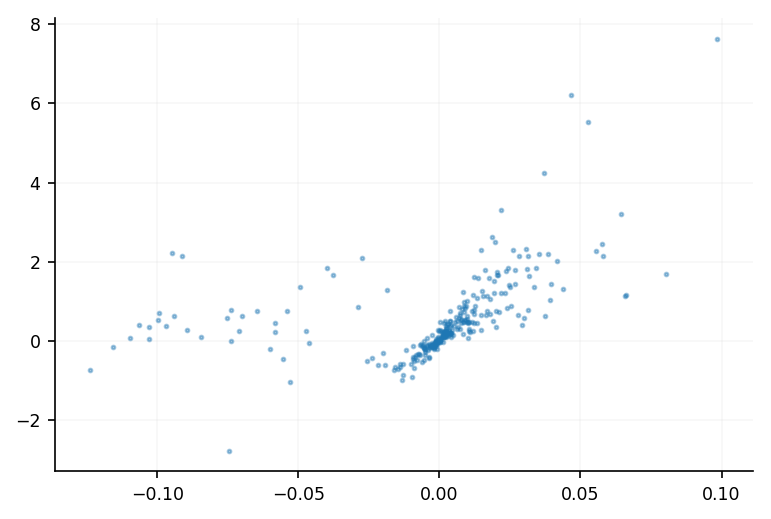

In [13]:
print(stats.pearsonr(mrl_diffs_df.locked_mrl_diff, mrl_diffs_df.locked_mrl_diff_z))
plt.scatter(mrl_diffs_df.locked_mrl_diff, mrl_diffs_df.locked_mrl_diff_z, s=3, alpha=0.4)

In [14]:
print(mrl_diffs_df.sig_locked_mrl_diff.mean())
display(mrl_diffs_df
        .query("(sig_locked_mrl_diff==True)")
        .groupby('sign_locked_mrl_diff')
        .agg({'unit': len, 'locked_mrl_diff': np.mean, 'locked_mrl_diff_z': np.mean}))

print(mrl_diffs_df.sig_locked_mrl_diff_z.mean())
display(mrl_diffs_df
        .query("(sig_locked_mrl_diff_z==True)")
        .groupby('sign_locked_mrl_diff_z')
        .agg({'unit': len, 'locked_mrl_diff': np.mean, 'locked_mrl_diff_z': np.mean}))

display(mrl_diffs_df
        .groupby(['sig_locked_mrl_diff_z', 'sign_locked_mrl_diff_z'])
        .agg({'unit': len, 'locked_mrl_diff': np.mean, 'locked_mrl_diff_z': np.mean}))

0.30201342281879195


,unit,locked_mrl_diff,locked_mrl_diff_z
sign_locked_mrl_diff,,,
-1.0,15,-0.028621,-0.803208
1.0,75,0.027081,1.666940


0.36577181208053694


,unit,locked_mrl_diff,locked_mrl_diff_z
sign_locked_mrl_diff_z,,,
-1.0,27,0.006594,0.907265
1.0,82,0.005323,1.345020


unit  locked_mrl_diff  \
sig_locked_mrl_diff_z sign_locked_mrl_diff_z                          
False                 -1.0                      66        -0.009106   
                       1.0                     123        -0.004031   
True                  -1.0                      27         0.006594   
                       1.0                      82         0.005323   

                                              locked_mrl_diff_z  
sig_locked_mrl_diff_z sign_locked_mrl_diff_z                     
False                 -1.0                             0.002078  
                       1.0                             0.134113  
True                  -1.0                             0.907265  
                       1.0                             1.345020

In [432]:
print(mrl_diffs_df.sig_locked_mrl_diff.mean())
display(mrl_diffs_df
        .query("(sig_locked_mrl_diff==True)")
        .groupby('sign_locked_mrl_diff')
        .agg({'unit': len, 'locked_mrl_diff': np.mean, 'locked_mrl_diff_z': np.mean}))

print(mrl_diffs_df.sig_locked_mrl_diff_z.mean())
display(mrl_diffs_df
        .query("(sig_locked_mrl_diff_z==True)")
        .groupby('sign_locked_mrl_diff_z')
        .agg({'unit': len, 'locked_mrl_diff': np.mean, 'locked_mrl_diff_z': np.mean}))

display(mrl_diffs_df
        .groupby(['sig_locked_mrl_diff_z', 'sign_locked_mrl_diff_z'])
        .agg({'unit': len, 'locked_mrl_diff': np.mean, 'locked_mrl_diff_z': np.mean}))

0.30201342281879195


,unit,locked_mrl_diff,locked_mrl_diff_z
sign_locked_mrl_diff,,,
-1.0,15,-0.028621,-0.803208
1.0,75,0.027081,1.666940


0.36577181208053694


,unit,locked_mrl_diff,locked_mrl_diff_z
sign_locked_mrl_diff_z,,,
-1.0,14,-0.030404,-0.831308
1.0,95,0.010949,1.541327


unit  locked_mrl_diff  \
sig_locked_mrl_diff_z sign_locked_mrl_diff_z                          
False                 -1.0                      75        -0.008133   
                       1.0                     114        -0.004270   
True                  -1.0                      14        -0.030404   
                       1.0                      95         0.010949   

                                              locked_mrl_diff_z  
sig_locked_mrl_diff_z sign_locked_mrl_diff_z                     
False                 -1.0                            -0.211849  
                       1.0                             0.285278  
True                  -1.0                            -0.831308  
                       1.0                             1.541327

In [434]:
14/298, 95/298, len(mrl_diffs_df)

(0.04697986577181208, 0.3187919463087248, 298)

In [ ]:
np.mean(mrl_diffs_df
          .apply(lambda x: tuple(x['qtl_mrls_z'][[i for i in range(16) if i not in [x['locked_freq_ind']]], :]), axis=1)
          .tolist(), axis=1)

In [502]:
x_locked = np.array(mrl_diffs_df
                    .apply(lambda x: tuple(x['qtl_mrls_z'][x['locked_freq_ind'], :]), axis=1)
                    .tolist())
x_nonlocked = np.mean(mrl_diffs_df
                      .apply(lambda x: tuple(x['qtl_mrls_z'][[i for i in range(16) if i not in [x['locked_freq_ind']]], :]), axis=1)
                      .tolist(), axis=1)
xsig_locked = np.array(mrl_diffs_df
                       .query("(sig_locked_mrl_diff_z==True)")
                       .apply(lambda x: tuple(x['qtl_mrls_z'][x['locked_freq_ind'], :]), axis=1)
                       .tolist())
xsig_nonlocked = np.mean(mrl_diffs_df
                         .query("(sig_locked_mrl_diff_z==True)")
                         .apply(lambda x: tuple(x['qtl_mrls_z'][[i for i in range(16) if i not in [x['locked_freq_ind']]], :]), axis=1)
                         .tolist(), axis=1)

In [19]:
mrl_diffs_df.shape, mrl_diffs_df.query("(local_sig_z==False)").shape, mrl_diffs_df.columns

((298, 28),
 (136, 28),
 Index(['subj_sess', 'unit', 'lfp2_hemroi', 'locked_freq_ind', 'qtl_mrls',
        'mrl_diffs', 'bs_qtl_mrls', 'bs_mrl_diffs', 'p_mrl_diffs',
        'sig_mrl_diffs', 'locked_mrl_diff', 'p_locked_mrl_diff',
        'sig_locked_mrl_diff', 'sign_locked_mrl_diff', 'qtl_mrls_z',
        'mrl_diffs_z', 'bs_qtl_mrls_z', 'bs_mrl_diffs_z', 'p_mrl_diffs_z',
        'sig_mrl_diffs_z', 'locked_mrl_diff_z', 'p_locked_mrl_diff_z',
        'sig_locked_mrl_diff_z', 'sign_locked_mrl_diff_z',
        'sig_nonlocked_mrl_diff_z', 'sign_nonlocked_mrl_diff_z',
        'local_locked_mrl_z', 'local_sig_z'],
       dtype='object'))

In [574]:
len(mrl_diffs_df.query("(local_sig_z==False) & (sig_locked_mrl_diff_z==True) & (sign_locked_mrl_diff_z==1)"))

(24, 28)

In [21]:
n = len(mrl_diffs_df.query("(local_sig_z==False)"))
df = [['Pos', 'Locked', len(mrl_diffs_df.query("(local_sig_z==False) & (sig_locked_mrl_diff==True) & (sign_locked_mrl_diff==1)"))/n],
      ['Neg', 'Locked', len(mrl_diffs_df.query("(local_sig_z==False) & (sig_locked_mrl_diff==True) & (sign_locked_mrl_diff==-1)"))/n],
      ['Pos', 'Remaining', len(mrl_diffs_df.query("(local_sig_z==False) & (sig_nonlocked_mrl_diff_z==True) & (sign_nonlocked_mrl_diff_z==1)"))/n],
      ['Neg', 'Remaining', len(mrl_diffs_df.query("(local_sig_z==False) & (sig_nonlocked_mrl_diff_z==True) & (sign_nonlocked_mrl_diff_z==-1)"))/n]]
df = pd.DataFrame(df, columns=['sign', 'band', 'pct'])
display(df)

n = len(mrl_diffs_df)
df = [['Pos', 'Locked', len(mrl_diffs_df.query("(sig_locked_mrl_diff==True) & (sign_locked_mrl_diff==1)"))/n],
      ['Neg', 'Locked', len(mrl_diffs_df.query("(sig_locked_mrl_diff==True) & (sign_locked_mrl_diff==-1)"))/n],
      ['Pos', 'Remaining', len(mrl_diffs_df.query("(sig_nonlocked_mrl_diff_z==True) & (sign_nonlocked_mrl_diff_z==1)"))/n],
      ['Neg', 'Remaining', len(mrl_diffs_df.query("(sig_nonlocked_mrl_diff_z==True) & (sign_nonlocked_mrl_diff_z==-1)"))/n]]
df = pd.DataFrame(df, columns=['sign', 'band', 'pct'])
display(df)

,sign,band,pct
0,Pos,Locked,0.132353
1,Neg,Locked,0.088235
2,Pos,Remaining,0.102941
3,Neg,Remaining,0.058824


,sign,band,pct
0,Pos,Locked,0.251678
1,Neg,Locked,0.050336
2,Pos,Remaining,0.261745
3,Neg,Remaining,0.043624


In [544]:
n = len(mrl_diffs_df)
df = [['Pos', 'Locked', 95/n],
      ['Neg', 'Locked', 14/n],
      ['Pos', 'Remaining', 78/n],
      ['Neg', 'Remaining', 13/n]]
df = pd.DataFrame(df, columns=['sign', 'band', 'pct'])
df

,sign,band,pct
0,Pos,Locked,0.318792
1,Neg,Locked,0.046980
2,Pos,Remaining,0.261745
3,Neg,Remaining,0.043624


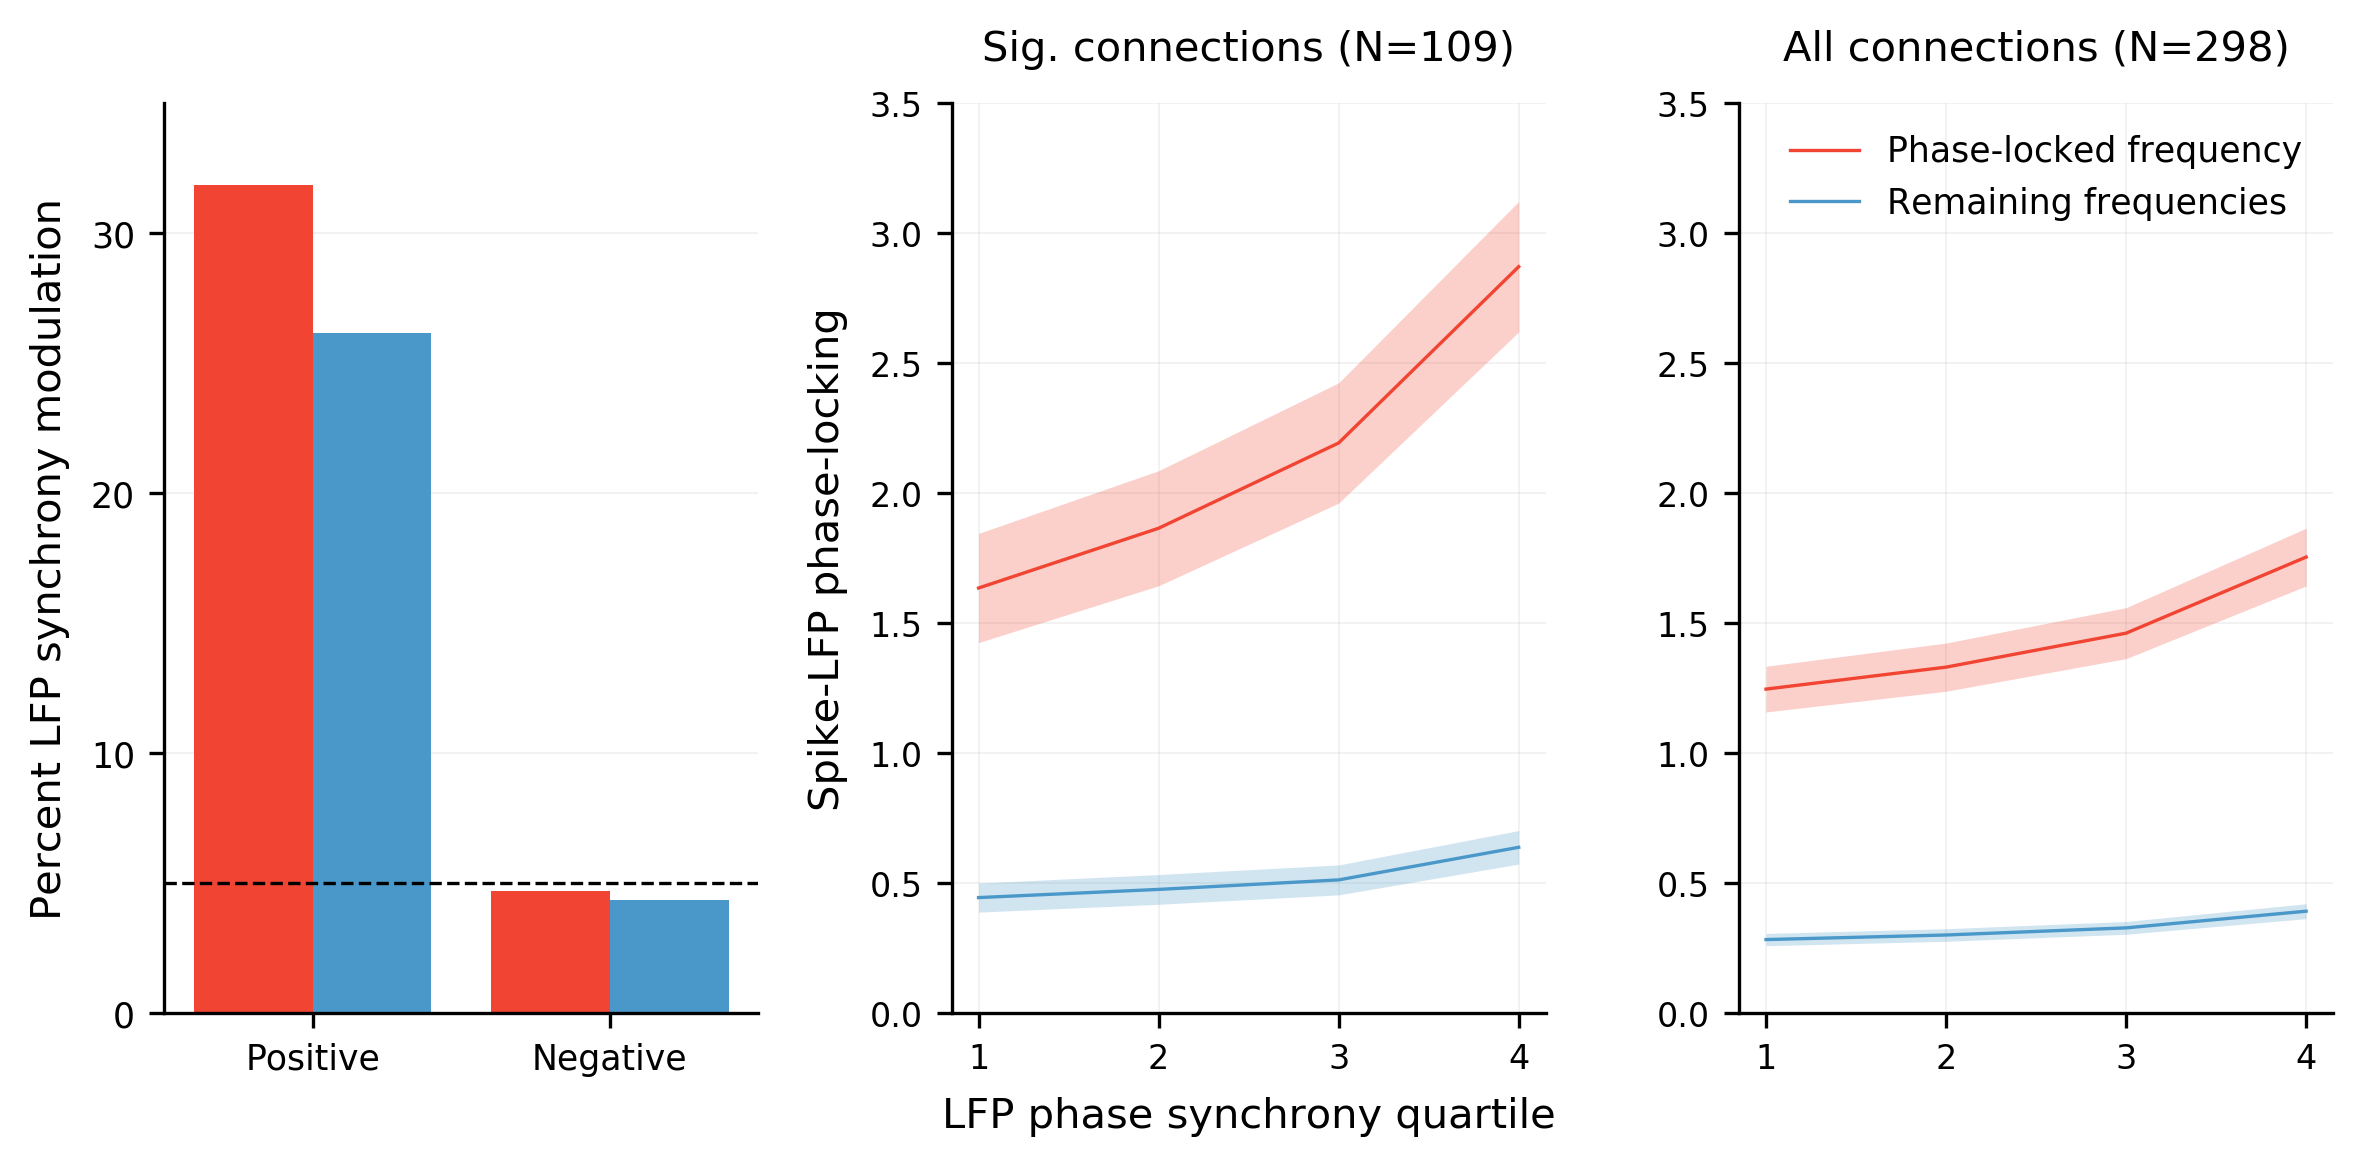

In [559]:
fig, ax = plt.subplots(1, 3, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

sns.barplot(x='sign', y='pct', hue='band', data=df, palette=[colors[1], colors[0]], saturation=100, ax=ax[0])
ax[0].axhline(y=0.05, color='k', linestyle='--')
ax[0].set_xticklabels(['Positive', 'Negative'])
ax[0].set_ylim([0, 0.35])
ax[0].set_yticks([0, 0.1, 0.2, 0.3])
ax[0].set_yticklabels([0, 10, 20, 30])
ax[0].set_xlabel('')
ax[0].set_ylabel('Percent LFP synchrony modulation', fontsize=10, labelpad=5)
ax[0].get_legend().remove()

ax[1].plot(np.mean(xsig_nonlocked, axis=0), color=colors[0])
ax[1].fill_between(np.arange(xsig_nonlocked.shape[1]), 
                   np.mean(xsig_nonlocked, axis=0) - stats.sem(xsig_nonlocked, axis=0), 
                   np.mean(xsig_nonlocked, axis=0) + stats.sem(xsig_nonlocked, axis=0), 
                   color=colors[0], alpha=0.25, linewidth=0)
ax[1].plot(np.mean(xsig_locked, axis=0), color=colors[1])
ax[1].fill_between(np.arange(xsig_locked.shape[1]), 
                   np.mean(xsig_locked, axis=0) - stats.sem(xsig_locked, axis=0), 
                   np.mean(xsig_locked, axis=0) + stats.sem(xsig_locked, axis=0), 
                   color=colors[1], alpha=0.25, linewidth=0)
ax[1].set_title('Sig. connections (N={})'.format(xsig_locked.shape[0]), fontsize=10, y=1.02)
ax[1].set_xlabel('LFP phase synchrony quartile', fontsize=10, labelpad=5)
ax[1].set_ylabel('Spike-LFP phase-locking', fontsize=10, labelpad=5)

ax[2].plot(np.mean(x_nonlocked, axis=0), color=colors[0])
ax[2].fill_between(np.arange(x_nonlocked.shape[1]), 
                   np.mean(x_nonlocked, axis=0) - stats.sem(x_nonlocked, axis=0), 
                   np.mean(x_nonlocked, axis=0) + stats.sem(x_nonlocked, axis=0), 
                   color=colors[0], alpha=0.25, linewidth=0)
ax[2].plot(np.mean(x_locked, axis=0), color=colors[1])
ax[2].fill_between(np.arange(x_locked.shape[1]), 
                   np.mean(x_locked, axis=0) - stats.sem(x_locked, axis=0), 
                   np.mean(x_locked, axis=0) + stats.sem(x_locked, axis=0), 
                   color=colors[1], alpha=0.25, linewidth=0)
ax[2].set_title('All connections (N={})'.format(x_locked.shape[0]), fontsize=10, y=1.02)

custom_lines = [Line2D([0], [0], label='Phase-locked frequency', color=colors[1]),
                Line2D([0], [0], label='Remaining frequencies', color=colors[0])]
legend = ax[2].legend(handles=custom_lines, loc=1)

for i in range(1, len(ax)):
    ax[i].set_xticks([0, 1, 2, 3])
    ax[i].set_xticklabels(['1', '2', '3', '4'], fontsize=8)
    ax[i].set_ylim([0, 3.4])
    ax[i].set_yticks(np.arange(0, 4, 0.5))
    ax[i].set_yticklabels(np.arange(0, 4, 0.5), fontsize=8)
    
fig.tight_layout(pad=1.12)

plt.show()

In [478]:
x_locked = np.array(mrl_diffs_df.apply(lambda x: tuple
               (
                   (x['qtl_mrls_z'][x['locked_freq_ind'], :] - np.mean(x['bs_qtl_mrls_z'][x['locked_freq_ind'], :, :], axis=0))
                   / np.std(x['bs_qtl_mrls_z'][x['locked_freq_ind'], :, :], axis=0)
               ), 
                                       axis=1).tolist())
x_nonlocked = np.array(mrl_diffs_df.apply(lambda x: tuple
                  (
                      (np.mean(x['qtl_mrls_z'][[i for i in range(16) if i not in [x['locked_freq_ind']]], :], axis=0) 
                       - np.mean(x['bs_qtl_mrls_z'][[i for i in range(16) if i not in [x['locked_freq_ind']]], :, :], axis=(0, 1)))
                      / np.std(x['bs_qtl_mrls_z'][[i for i in range(16) if i not in [x['locked_freq_ind']]], :, :], axis=(0, 1))
                  ), 
                                          axis=1).tolist())
xsig_locked = np.array(mrl_diffs_df
                       .query("(sig_locked_mrl_diff_z==True)")
                       .apply(lambda x: tuple
                  (
                      (x['qtl_mrls_z'][x['locked_freq_ind'], :] - np.mean(x['bs_qtl_mrls_z'][x['locked_freq_ind'], :, :], axis=0))
                      / np.std(x['bs_qtl_mrls_z'][x['locked_freq_ind'], :, :], axis=0)
                  ), 
                              axis=1).tolist())
xsig_nonlocked = np.array(mrl_diffs_df
                          .query("(sig_locked_mrl_diff_z==True)")
                          .apply(lambda x: tuple
                     (
                         (np.mean(x['qtl_mrls_z'][[i for i in range(16) if i not in [x['locked_freq_ind']]], :], axis=0)
                          - np.mean(x['bs_qtl_mrls_z'][[i for i in range(16) if i not in [x['locked_freq_ind']]], :, :], axis=(0, 1)))
                         / np.std(x['bs_qtl_mrls_z'][[i for i in range(16) if i not in [x['locked_freq_ind']]], :, :], axis=(0, 1))
                     ), 
                                 axis=1).tolist())

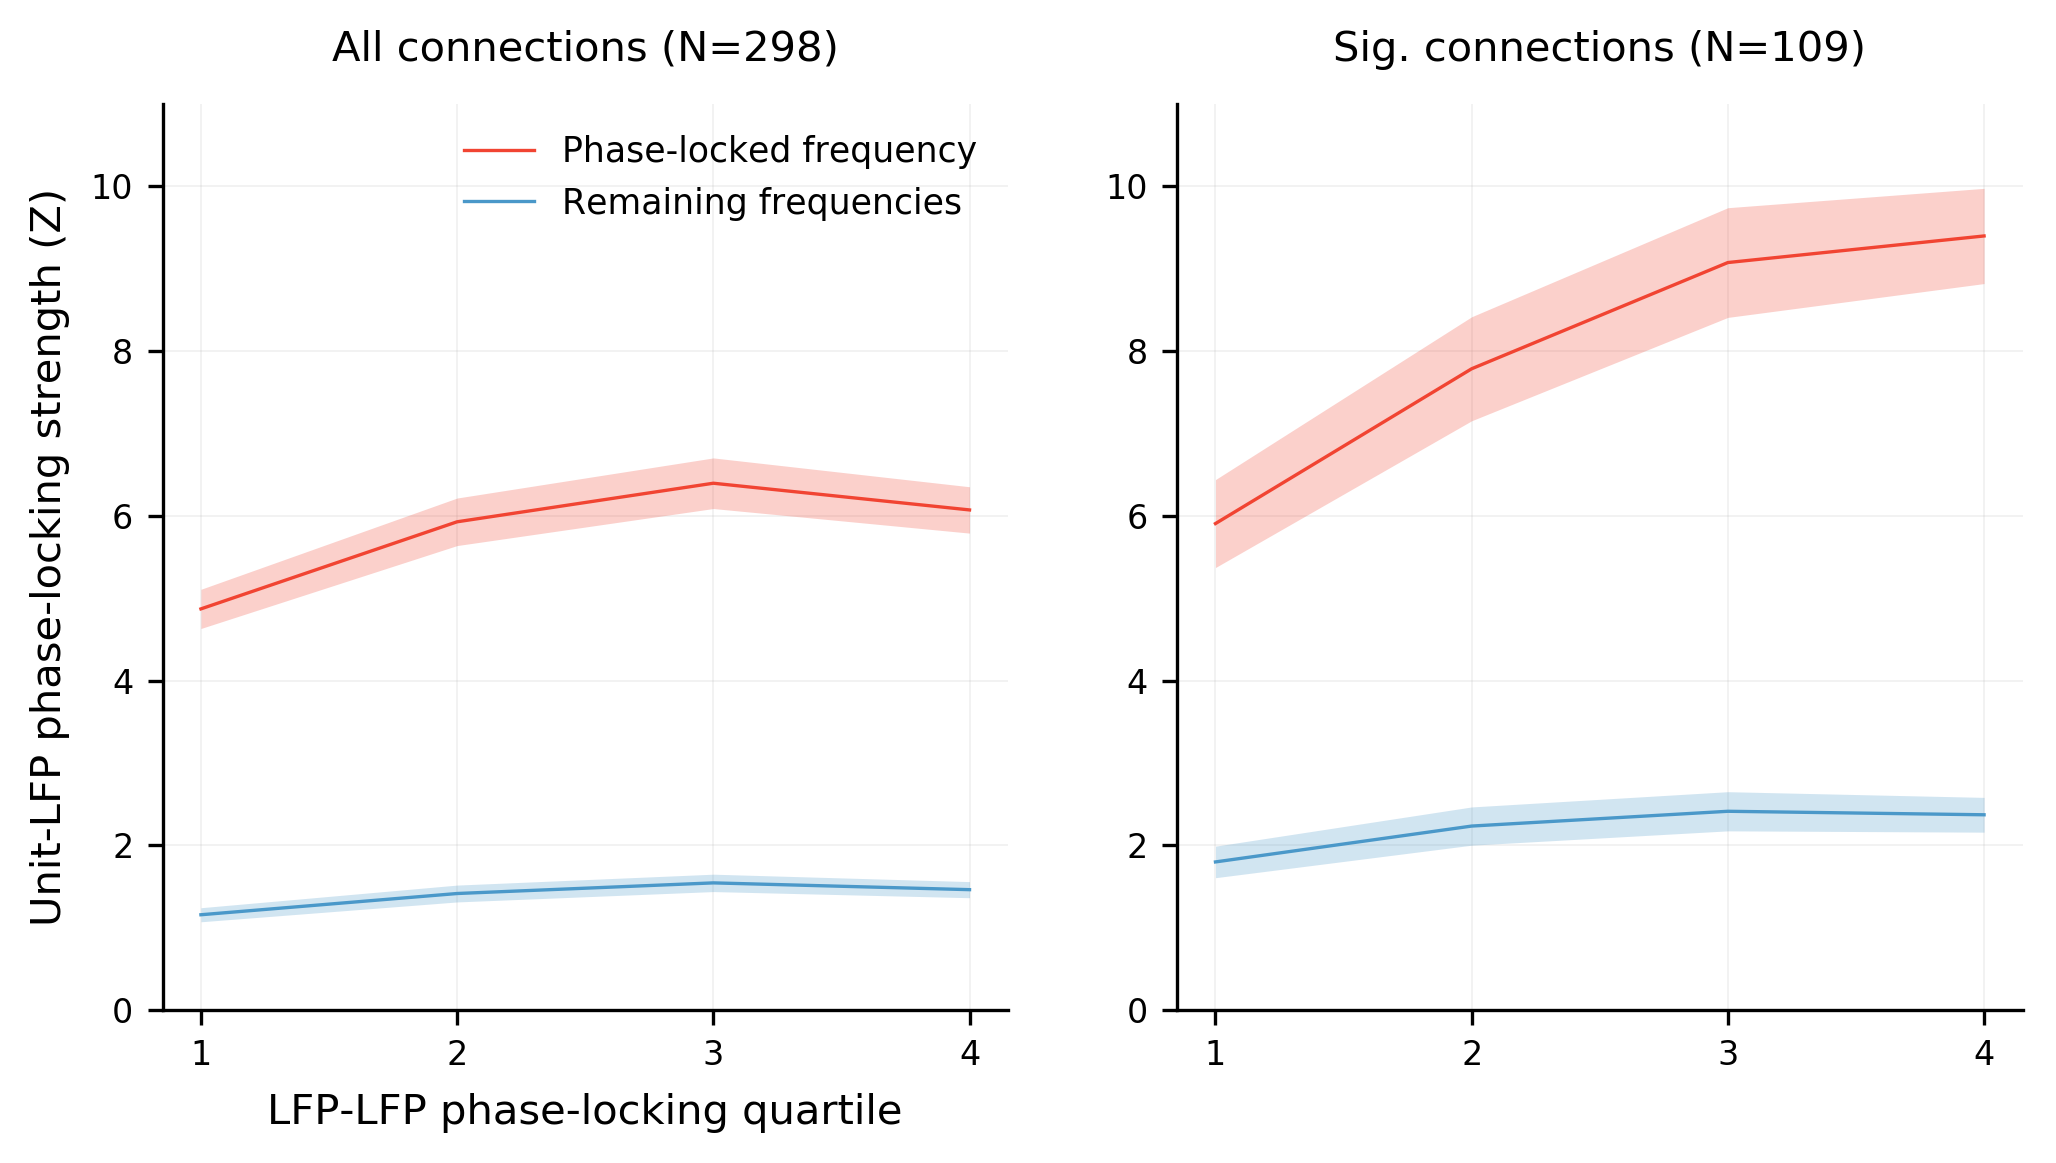

In [501]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

ax[0].plot(np.mean(x_nonlocked, axis=0), color=colors[0])
ax[0].fill_between(np.arange(x_nonlocked.shape[1]), 
                   np.mean(x_nonlocked, axis=0) - stats.sem(x_nonlocked, axis=0), 
                   np.mean(x_nonlocked, axis=0) + stats.sem(x_nonlocked, axis=0), 
                   color=colors[0], alpha=0.25, linewidth=0)
ax[0].plot(np.mean(x_locked, axis=0), color=colors[1])
ax[0].fill_between(np.arange(x_locked.shape[1]), 
                   np.mean(x_locked, axis=0) - stats.sem(x_locked, axis=0), 
                   np.mean(x_locked, axis=0) + stats.sem(x_locked, axis=0), 
                   color=colors[1], alpha=0.25, linewidth=0)
ax[0].set_title('All connections (N={})'.format(x_locked.shape[0]), fontsize=10, y=1.02)

ax[1].plot(np.mean(xsig_nonlocked, axis=0), color=colors[0])
ax[1].fill_between(np.arange(xsig_nonlocked.shape[1]), 
                   np.mean(xsig_nonlocked, axis=0) - stats.sem(xsig_nonlocked, axis=0), 
                   np.mean(xsig_nonlocked, axis=0) + stats.sem(xsig_nonlocked, axis=0), 
                   color=colors[0], alpha=0.25, linewidth=0)
ax[1].plot(np.mean(xsig_locked, axis=0), color=colors[1])
ax[1].fill_between(np.arange(xsig_locked.shape[1]), 
                   np.mean(xsig_locked, axis=0) - stats.sem(xsig_locked, axis=0), 
                   np.mean(xsig_locked, axis=0) + stats.sem(xsig_locked, axis=0), 
                   color=colors[1], alpha=0.25, linewidth=0)
ax[1].set_title('Sig. connections (N={})'.format(xsig_locked.shape[0]), fontsize=10, y=1.02)

ax[0].set_xlabel('LFP-LFP phase-locking quartile', fontsize=10, labelpad=5)
ax[0].set_ylabel('Unit-LFP phase-locking strength (Z)', fontsize=10, labelpad=5)

custom_lines = [Line2D([0], [0], label='Phase-locked frequency', color=colors[1]),
                Line2D([0], [0], label='Remaining frequencies', color=colors[0])]
legend = ax[0].legend(handles=custom_lines, loc=1)

for i in range(len(ax)):
    ax[i].set_xticks([0, 1, 2, 3])
    ax[i].set_xticklabels(['1', '2', '3', '4'], fontsize=8)
    ax[i].set_ylim([0, 11])
    ax[i].set_yticks(np.arange(0, 11, 2))
    ax[i].set_yticklabels(np.arange(0, 11, 2), fontsize=8)

In [204]:
alpha = 0.05

bs_qtl_mrls_z = np.array([stats.zscore(x.bs_qtl_mrls, axis=1) for x in dat]) # chan_pair x freq x bootstrap_ind x quartile
qtl_mrls_z = np.array([(x.qtl_mrls - np.mean(x.bs_qtl_mrls, axis=1)) / np.std(x.bs_qtl_mrls, axis=1) for x in dat]) # chan_pair x freq x quartile
bs_mrl_diffs_z = bs_qtl_mrls_z[:, :, :, -1] - bs_qtl_mrls_z[:, :, :, 0]
mrl_diffs_z = qtl_mrls_z[:, :, -1] - qtl_mrls_z[:, :, 0]

bs_qtl_mrls_z = np.mean(bs_qtl_mrls_z, axis=0)
qtl_mrls_z = np.mean(qtl_mrls_z, axis=0)
bs_mrl_diffs_z = np.mean(bs_mrl_diffs_z, axis=0)
mrl_diffs_z = np.mean(mrl_diffs_z, axis=0)

p_mrl_diffs_z = ((1 + np.array([np.sum(abs(bs_mrl_diffs_z[i, :]) >= abs(mrl_diffs_z[i])) for i in range(len(mrl_diffs_z))])) 
                 / (1 + bs_mrl_diffs_z.shape[1]))
sig_mrl_diffs_z = p_mrl_diffs_z < alpha

p_locked_mrl_diffs_z = p_mrl_diffs_z[locked_freq]
sig_locked_mrl_diffs_z = sig_mrl_diffs_z[locked_freq]
sign_locked_mrl_diffs_z = np.sign(sig_locked_mrl_diffs_z)

output.append([subj_sess, unit, lfp2_hemroi, locked_freq,
               qtl_mrls_z, mrl_diffs_z, p_mrl_diffs_z, sig_mrl_diffs_z,
               p_locked_mrl_diffs_z, sig_locked_mrl_diffs_z, sign_locked_mrl_diffs_z])

In [207]:
bs_qtl_mrls = np.array([x.bs_qtl_mrls for x in dat]) # chan_pair x freq x bootstrap_ind x quartile
qtl_mrls = np.array([x.qtl_mrls for x in dat]) # chan_pair x freq x quartile

bs_mrl_diffs = bs_qtl_mrls[:, :, :, -1] - bs_qtl_mrls[:, :, :, 0]
mrl_diffs = qtl_mrls[:, :, -1] - qtl_mrls[:, :, 0]

bs_qtl_mrls = np.mean(bs_qtl_mrls, axis=0)
qtl_mrls = np.mean(qtl_mrls, axis=0)
bs_mrl_diffs = np.mean(bs_mrl_diffs, axis=0)
mrl_diffs = np.mean(mrl_diffs, axis=0)

p_mrl_diffs = ((1 + np.array([np.sum(abs(bs_mrl_diffs[i, :]) >= abs(mrl_diffs[i])) for i in range(len(mrl_diffs))])) 
                 / (1 + bs_mrl_diffs.shape[1]))

In [212]:
p_mrl_diffs_z, p_mrl_diffs

(array([0.96806387, 0.82834331, 0.62874251, 0.65868263, 0.33133733,
        0.6746507 , 0.18962076, 0.01796407, 0.93213573, 0.00399202,
        0.21357285, 0.03792415, 0.34530938, 0.46107784, 0.09780439,
        0.75648703]),
 array([0.72255489, 0.83433134, 0.76447106, 0.54491018, 0.33932136,
        0.65868263, 0.23552894, 0.01996008, 0.9241517 , 0.00399202,
        0.19361277, 0.03992016, 0.42315369, 0.499002  , 0.08982036,
        0.69660679]))

In [175]:
np.array_equal(stats.zscore(dat[0].bs_qtl_mrls, axis=1), bs_qtl_mrls_z[0, :, :, :])

True

In [170]:
np.std(bs_qtl_mrls_z[1, :, 1]), np.std(bs_qtl_mrls_z)

(0.15931033175944845, 0.2567617615261728)

In [145]:
np.array_equal(np.array([(x.qtl_mrls - np.mean(x.bs_qtl_mrls, axis=1)) / np.std(x.bs_qtl_mrls, axis=1) for x in dat]),
               np.array([x.qtl_mrls_z for x in dat]))

True

In [143]:
qtl_mrls_z = np.mean(np.array([x.qtl_mrls_z for x in dat]), axis=0)

(16, 4)

In [132]:
info = dio.open_pickle(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/lfp_plvs/plvs/mrl_diffs',
                                    'mrl_plv_diffs-U369_env1-unit_0-to-RMH-chan_ind_1-to-chan_ind_10-500Hz-notch60_120Hz-nospikeinterp-5cycles-16log10freqs_0.5_to_16.0Hz.pkl'))

In [133]:
info

subj_sess                                                  U369_env1
unit                                                               0
unit_chan_ind                                                      0
lfp1_chan_ind                                                      1
lfp2_chan_ind                                                     10
lfp1_hemroi                                                       RA
lfp2_hemroi                                                      RMH
locked_freq_ind                                                   12
sig                                                             True
bs_qtl_mrls        [[[0.05974258664055439, 0.05702759394598165, 0...
bs_mrl_diffs       [[-0.016356984917367257, -0.01590537279045104,...
qtl_mrls           [[0.01878979189462172, 0.06769046930572817, 0....
mrl_diffs          [0.034071464002128085, -0.08730267639673957, 0...
qtl_mrls_z         [[-1.305707658612968, 0.28117618656764143, 0.0...
mrl_diffs_z        [1.127794775793

In [ ]:
def calc_phase_locking_fr_power_differences(subj_sess,
                                            bands=None,
                                            interp_spikes=False,
                                            notch_freqs=[60, 120],
                                            zscore_lfp=True,
                                            zscore_power=True,
                                            phase_type='extrema2', 
                                            hpc_subset=True,
                                            n_bootstraps=1000,
                                            save_outputs=True,
                                            output_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking'):
    """Calculate phase-locking between each unit and each channel LFP, 
    for a given set of frequency bands.
    
    Returns
    -------
    upl_df : pd.DataFrame
        The cross-electrode phase-locking DataFrame (all unit-to-LFP regional pairs).
    """
    band_names = list(bands.keys())
    
    # Get session info.
    subj_df = get_subj_df()

    # Load spikes.
    spikes, fr_df, clus_to_chan, chan_to_clus = load_spikes(subj_sess)
    units = fr_df.clus.tolist()

    # Load the raw LFP.
    ms_before = 2
    ms_after = 4
    lfp_raw, lfp_preproc = manning_analysis.process_lfp(subj_sess, 
                                                        subj_df=subj_df, 
                                                        notch_freqs=notch_freqs,
                                                        interpolate=interp_spikes,
                                                        session_spikes=spikes,
                                                        ms_before=ms_before,
                                                        ms_after=ms_after)
    del lfp_raw, spikes

    # Bandpass filter the LFP.
    lfp_filt = spp.filter_lfp_bands(lfp_preproc, 
                                    bands=bands, 
                                    zscore_lfp=zscore_lfp)

    # Use a derivative test to identify troughs and peaks in the filtered 
    # LFP, then linearly interpolate phase between cycles.
    phase = get_phase_bands(lfp_filt, 
                            bands=bands, 
                            find=phase_type, 
                            lims=[-np.pi, np.pi])

    # Get Hilbert transform phase (instead of linearly interpolated phase).
    power = OrderedDict()
    for band_name, pass_band in bands.items():
        power[band_name], _ = spp.get_hilbert(lfp_filt[band_name], 
                                              zscore_power=zscore_power)
    del _

    # Load the cross-electrode DataFrame.
    pl_df = dio.open_pickle(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking',
                                         '{}_cross_electrode_unit_lfp_pairs_df.pkl'.format(subj_sess)))
    upl_df = dio.open_pickle(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking',
                                          '{}_crosselec_phaselock_byunit_df_notch60-120_nospikeinterp_phase-extrema2_nomask_timelag-2to2sec-step10ms_1000bootstraps2_hpc-subset_bands--sub_delta0.5-2--delta1-4--low_theta2-8--high_theta4-16--alpha_beta8-32.pkl'.format(subj_sess)))
    pl_df = pd.merge(pl_df, upl_df[['subj_sess_unit', 'lfp_is_hpc', 'mrl_argmax', 'locked_band', 'sig']], 
                     how='inner', on=['subj_sess_unit', 'lfp_is_hpc'])
    del upl_df

    # Restrict analyses to a subset of pairs.
    if hpc_subset:
        # Remove inter-hemispheric pairs.
        pl_df = pl_df.loc[pl_df.same_hem==True]
        # Remove same-channel pairs.
        pl_df = pl_df.loc[pl_df.same_chan!=True]
        # Remove intra-regional pairs from different microwire bundles.
        pl_df = pl_df.query("(unit_roi2!=lfp_roi2) | ((unit_roi2==lfp_roi2) & (same_hemroi==True))")
        # Remove pairs that aren't intra-regional and where the LFP is extra-hippocampal.
        pl_df = pl_df.query("(lfp_is_hpc==True) | (unit_roi2==lfp_roi2)")
        # Remove units with <250 spikes.
        pl_df = pl_df.loc[pl_df.unit_nspikes>249]
        # Remove units that don't have connections to HPC.
        keep_units = pl_df.query("(lfp_is_hpc==True)").groupby(['subj_sess_unit']).size().index.tolist()
        pl_df = pl_df.query("(subj_sess_unit=={})".format(keep_units))
        # Remove insignificant units.
        pl_df = pl_df.query("(sig==True)")

    pl_df = pl_df.reset_index(drop=True).copy()

    # Get phase-locking differences between top and bottom quartiles
    # of spike phases, sorted by firing rate, power of the locked band,
    # and power of the remaining bands.
    pl_diffs = []
    bs_pl_diffs = []
    n_timepoints = len(fr_df.at[0, 'spikes'])
    bs_offsets_fr = np.array([4000+int(random.random() * (n_timepoints-4001)) 
                              for _ in range(n_bootstraps)])
    bs_offsets_pow = np.array([4000+int(random.random() * (n_timepoints-4001)) 
                               for _ in range(n_bootstraps)])
    for iunit in range(len(pl_df)):
        pl_diffs.append(get_pl_diffs_pair(iunit, pl_df, fr_df, power, phase, band_names, offset=0))

        # Get bootstrap estimates by shuffling spike trains and recalculating values.
        bs_fr_vec = []
        bs_pow_locked_vec = []
        bs_pow_nonlocked_vec = []
        for iperm in range(n_bootstraps):
            bs_fr_vec.append(get_pl_diffs_pair(iunit, pl_df, fr_df, power, phase, band_names, offset=bs_offsets_fr[iperm])['fr'])
            output = get_pl_diffs_pair(iunit, pl_df, fr_df, power, phase, band_names, offset=bs_offsets_pow[iperm])
            bs_pow_locked_vec.append(output['pow_locked'])
            bs_pow_nonlocked_vec.append(output['pow_nonlocked'])
        bs_pl_diffs.append(OrderedDict([('fr', np.array(bs_fr_vec)),
                                        ('pow_locked', np.array(bs_pow_locked_vec)),
                                        ('pow_nonlocked', np.array(bs_pow_nonlocked_vec))]))

    # Append results to the phase-locking DataFrame.
    pl_df['pl_diffs_fr'] = [x['fr'] for x in pl_diffs]
    pl_df['pl_diffs_pow_locked'] = [x['pow_locked'] for x in pl_diffs]
    pl_df['pl_diffs_pow_nonlocked'] = [x['pow_nonlocked'] for x in pl_diffs]
    pl_df['bs_pl_diffs_fr'] = [x['fr'] for x in bs_pl_diffs]
    pl_df['bs_pl_diffs_pow_locked'] = [x['pow_locked'] for x in bs_pl_diffs]
    pl_df['bs_pl_diffs_pow_nonlocked'] = [x['pow_nonlocked'] for x in bs_pl_diffs]

    # Collapse the DataFrame into unit->LFP pairs for unit->local and unit->HPC 
    # connections, and determine significance vs. bootstrap estimates.
    alpha = 0.05
    upl_df = (pl_df.groupby(['subj_sess_unit', 'subj_sess', 'unit_roi2', 'lfp_roi2', 
                             'unit_hem', 'lfp_hem', 'unit_is_hpc', 'lfp_is_hpc', 
                             'unit_fr', 'unit_nspikes'])
                   .agg({'pl_diffs_fr': np.mean,
                         'pl_diffs_pow_locked': np.mean,
                         'pl_diffs_pow_nonlocked': np.mean,
                         'bs_pl_diffs_fr': lambda x: tuple(np.mean(x)),
                         'bs_pl_diffs_pow_locked': lambda x: tuple(np.mean(x)),
                         'bs_pl_diffs_pow_nonlocked': lambda x: tuple(np.mean(x))})
                   .reset_index())
    upl_df['pl_diffs_fr_sign'] = upl_df.pl_diffs_fr.apply(np.sign)
    upl_df['pl_diffs_pow_locked_sign'] = upl_df.pl_diffs_pow_locked.apply(np.sign)
    upl_df['pl_diffs_pow_nonlocked_sign'] = upl_df.pl_diffs_pow_nonlocked.apply(np.sign)
    upl_df['bs_pl_diffs_fr'] = upl_df.bs_pl_diffs_fr.apply(lambda x: np.array(x))
    upl_df['bs_pl_diffs_pow_locked'] = upl_df.bs_pl_diffs_pow_locked.apply(lambda x: np.array(x))
    upl_df['bs_pl_diffs_pow_nonlocked'] = upl_df.bs_pl_diffs_pow_nonlocked.apply(lambda x: np.array(x))
    upl_df['pl_diffs_fr_pval'] = upl_df.apply(lambda x: (1 + np.sum(abs(x['bs_pl_diffs_fr']) >= 
                                                                    abs(x['pl_diffs_fr']))) / (1 + n_bootstraps), axis=1)
    upl_df['pl_diffs_pow_locked_pval'] = upl_df.apply(lambda x: (1 + np.sum(abs(x['bs_pl_diffs_pow_locked']) >= 
                                                                            abs(x['pl_diffs_pow_locked']))) / (1 + n_bootstraps), axis=1)
    upl_df['pl_diffs_pow_nonlocked_pval'] = upl_df.apply(lambda x: (1 + np.sum(abs(x['bs_pl_diffs_pow_nonlocked']) >= 
                                                                               abs(x['pl_diffs_pow_nonlocked']))) / (1 + n_bootstraps), axis=1)
    upl_df['pl_diffs_fr_sig'] = upl_df.pl_diffs_fr_pval < alpha
    upl_df['pl_diffs_pow_locked_sig'] = upl_df.pl_diffs_pow_locked_pval < alpha
    upl_df['pl_diffs_pow_nonlocked_sig'] = upl_df.pl_diffs_pow_nonlocked_pval < alpha
    upl_df = upl_df.loc[:, [col for col in upl_df.columns if col[:3] != 'bs_']]

    # Save the cross-electrode phase-locking DataFrame.
    process_str = ''
    process_str += 'notch' + '-'.join(str(i) for i in notch_freqs) if notch_freqs else 'nonotch'
    process_str += '_spikeinterp-{}to{}ms'.format(ms_before, ms_after) if interp_spikes else '_nospikeinterp'
    process_str += '_phase-{}'.format(phase_type)
    process_str += '_nomask'
    process_str += '_{}bootstraps2'.format(n_bootstraps)
    process_str += '_hpc-subset' if hpc_subset else ''
    process_str += '_bands--' + '--'.join(['{}{}-{}'.format(key, val[0], val[1]) for key, val in bands.items()])
    if save_outputs:
        fpath = os.path.join(output_dir, '{}_crosselec_phaselock_byunit_df_fr_power_diffs_{}.pkl'.format(subj_sess, process_str))
        dio.save_pickle(upl_df, fpath)

    return upl_df

In [13]:
# Get the mean phase-locking value across all channel comparisons for each
# unit-to-hippocampal region pair.
start_time = time()

pl_df_ = pl_df.query("(edge=='ctx-hpc')").reset_index(drop=True)
plv_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/lfp_plvs/plvs/mrl_diffs/'
fname = 'mrl_plv_diffs-{}-unit_{}-to-{}-chan_ind_{}-to-chan_ind_{}-500Hz-notch60_120Hz-nospikeinterp-5cycles-16log10freqs_0.5_to_16.0Hz.pkl'
add_cols = OrderedDict([('plvs', []),
                        ('plvs_z', [])])
drop_groups = []
grouped = get_plv_df.groupby(['subj_sess', 'unit', 'lfp2_hemroi'])




for index, row in pl_df_.iterrows():
    subj_sess = row.subj_sess
    unit = row.unit
    roi = row.lfp_hemroi
    plv_file = os.path.join(plv_dir, fname.format(subj_sess, unit, roi))
    if os.path.exists(plv_file):
        plv_dat = dio.open_pickle(plv_file)
        for key in add_cols.keys():
            add_cols[key].append(plv_dat[key])
    else:
        drop_rows.append(index)
    if index % 100 == 0 or index == len(pl_df_):
        print('{}: {:.0f} secs'.format(index, time() - start_time))

pl_df_ = pl_df_.drop(index=drop_rows).reset_index(drop=True)
for key in add_cols.keys():
    pl_df_[key] = add_cols[key]
    
print('Done in {:.2f} secs'.format(time() - start_time))

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/dscho/unit_activity_and_hpc_theta/data/lfp_plvs/plvs/get_plv_df.pkl'

In [12]:
pl_df.head()

,subj_sess,subj_sess_unit,unit,unit_chan_ind,unit_hemroi,unit_hem,unit_roi,unit_is_hpc,unit_nspikes,unit_fr,...,locked_mrl_z,bs_ind_z,bs_pval_z,sig_z,tl_locked_time_ind_z,tl_locked_time_z,tl_locked_time_mrl_z,tl_bs_ind_z,tl_bs_pval_z,tl_bs_sig_z
0,U387_ses3,U387_ses3_5,5,19,LA,L,A,0,792,0.430277,...,0.485218,648,0.129774,False,139,-3610.0,1.895585,"[78, 310, 306, 304, 304, 309, 314, 323, 437, 3...","[0.015796840631873626, 0.0621875624875025, 0.0...","[False, False, False, False, False, False, Fal..."
1,U372_ses2,U372_ses2_17,17,28,LEC,L,EC,0,363,0.217948,...,0.541199,579,0.115977,False,523,230.0,0.698529,"[41, 34, 35, 35, 35, 38, 41, 41, 42, 46, 50, 5...","[0.008398320335932814, 0.006998600279944011, 0...","[False, False, False, False, False, False, Fal..."
2,U387_ses3,U387_ses3_16,16,37,LAH,L,AH,1,903,0.490581,...,1.851504,0,0.000200,True,474,-260.0,1.938403,"[870, 826, 695, 577, 720, 712, 685, 675, 657, ...","[0.17416516696660667, 0.16536692661467706, 0.1...","[False, False, False, False, False, False, Fal..."
3,U369_env1,U369_env1_27,27,25,RPS,R,PS,0,771,0.607977,...,0.903860,76,0.015397,False,495,-50.0,1.120573,"[238, 227, 222, 217, 215, 218, 216, 215, 216, ...","[0.04779044191161767, 0.04559088182363527, 0.0...","[False, False, False, False, False, False, Fal..."
4,U372_ses2,U372_ses2_23,23,43,LPG,L,PG,0,757,0.454509,...,1.168019,101,0.020396,False,726,2260.0,1.619202,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0001999600079984003, 0.0001999600079984003,...","[True, True, True, True, True, True, True, Tru..."
